In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import random_split
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# NOTE: for some reason mps is much slower than cpu. commented off for now

# if torch.backends.mps.is_built() and torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device("cpu")

device = torch.device("cpu")

In [3]:
with open("names.txt", "r") as f:
    names = [_.strip() for _ in f.readlines()]

names[0:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [4]:
len(names)

32033

In [5]:
chars = list(set("".join(names)))
chars.sort()
chars.insert(0, ".")

chars[0:5]

['.', 'a', 'b', 'c', 'd']

In [6]:
ctoi = {c:i for i, c in enumerate(chars)}
itoc = {i:c for i, c in enumerate(chars)}

ctoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [7]:
ctx_size=3

def create_ds(names):
    X = [] # (m, 3)
    Y = [] # (m)

    for s in names:
        s = s + "."
        ctx = [0] * ctx_size
        for c in s:
            ix = ctoi[c]
            X.append(ctx)
            Y.append(ix)
            ctx = list(ctx[1:])
            ctx.append(ix)

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y

X, Y = create_ds(names)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [8]:
X[0:5]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])

In [9]:
names[0]

'emma'

In [10]:
[ctoi[c] for c in names[0]]

[5, 13, 13, 1]

In [11]:
[train, dev, test] = random_split(names, [0.8, 0.1, 0.1])
x_train, y_train = create_ds(train)
x_dev, y_dev = create_ds(dev)
x_test, y_test = create_ds(test)

In [78]:
def init_params(emb_size=10, hidden_size=100):
    C = torch.normal(0, 1, (27, emb_size))
    W1 = torch.normal(0, 0.1, (emb_size * ctx_size, hidden_size))
    b1 = torch.zeros(hidden_size)
    W2 = torch.normal(0, 0.1, (hidden_size, 27))
    b2 = torch.zeros(27)
    params = [C, W1, b1, W2, b2]

    for p in params:
        p.requires_grad = True
    
    return params

params = init_params()
sum([_.nelement() for _ in params])

6097

In [79]:
def forward(x, y, params, weight_decay=0):
    C, W1, b1, W2, b2 = params
    ctx_size = x.shape[1]
    emb_size = C.shape[1]
    
    emb = C[x].view(-1, emb_size * ctx_size)
    h = emb @ W1 + b1
    h = h.tanh()
    h = h @ W2 + b2
    l2 = weight_decay * ((W1**2).mean() + (W2**2).mean())
    loss = F.cross_entropy(h, y) + l2
    return loss

In [75]:
import math
def exp_decay(t, start_lr, lr_decay):
    k = 0.00001
    lr = start_lr * math.exp(-lr_decay*t)
    return lr

In [76]:
batch_size = 32

def fit(params, lr, epoch, loss_train=True, loss_dev=True, lr_decay=0, weight_decay=0):
    C, W1, b1, W2, b2 = params
    start_lr = lr
    
    for t in range(epoch):
        ix = torch.randint(0, x_train.shape[0], (batch_size,), device=device)
        x = x_train[ix]
        y = y_train[ix]

        for p in params:
            p.grad = None

        loss = forward(x, y, params, weight_decay)
        loss.backward()

        for p in params:
            p.data -= lr * p.grad
        
        lr = exp_decay(t, start_lr, lr_decay)

    with torch.no_grad():
        loss_tr = forward(x_train, y_train, params).item() if loss_train else None
        loss_d = forward(x_dev, y_dev, params).item() if loss_dev else None
    
    return loss_tr, loss_d

In [80]:
%%time
params = init_params()
fit(params, 0.1, 50000, weight_decay=0.1)

CPU times: user 9.93 s, sys: 1.42 s, total: 11.3 s
Wall time: 10.2 s


(2.1701745986938477, 2.192361831665039)

## Learning Rate Search

In [72]:
def try_ls(lr):
    params = init_params(emb_size=10, hidden_size=100)
    _, loss_d = fit(params, lr, 10000, loss_train=False, loss_dev=True)
    return loss_d

In [ ]:
lrs = torch.linspace(-8, 0, steps=100).exp()
len(lrs)

In [ ]:
loss = [try_ls(lr) for lr in tqdm(lrs)]

In [76]:
min(zip(lrs, loss), key=lambda k:k[1])

(tensor(0.1128), 2.3968825340270996)

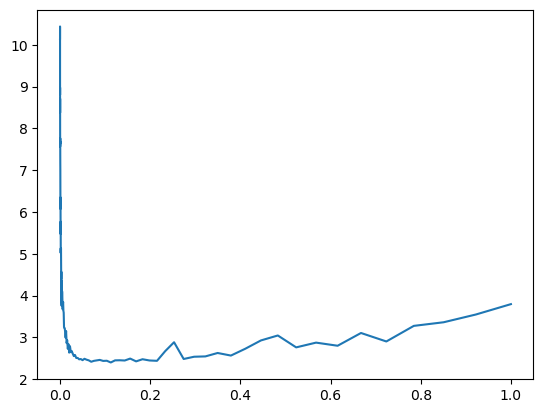

In [75]:
plt.plot(lrs, loss)

Further narrow down the choice

In [80]:
lrs = torch.linspace(-5, -1.5, steps=100).exp()
len(lrs)

100

In [97]:
loss = [try_ls(lr) for lr in tqdm(lrs)]
min(zip(lrs, loss), key=lambda k:k[1])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


(tensor(0.0720), 2.3719685077667236)

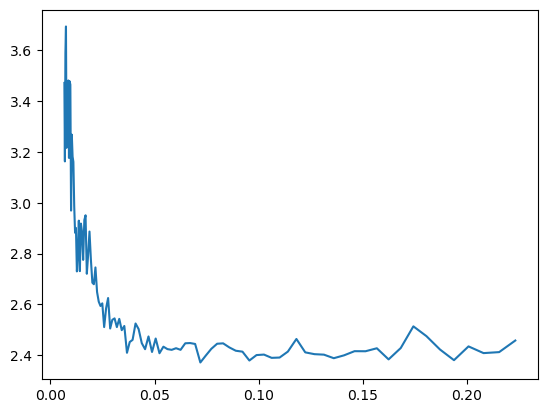

In [99]:
plt.plot(lrs, loss)

## Hyper-Parameter Search

In [ ]:
emb_sizes = range(2, 30, 1)
hidden_sizes = range(50, 200, 5)

def try_param(embed_size, hidden_size):
    params = init_params(embed_size, hidden_size)
    loss_t, loss_d = fit(params, 0.07, 10000)
    return loss_t, loss_d

result = []
param_set = [(e, h) for e in emb_sizes for h in hidden_sizes]

for (e, h) in tqdm(param_set):
    loss_t, loss_d = try_param(e, h)
    result.append([e, h, loss_t, loss_d])

In [ ]:
min(result, key = lambda k: k[3])

In [ ]:
xs = [_[0] for _ in result]
ys = [_[1] for _ in result]
zs = [_[3] for _ in result]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('embed')
ax.set_ylabel('hidden')
ax.set_zlabel('dev loss')

## Train Final Model

In [58]:
params = init_params(10, 200)
print(fit(params, 0.1, 100000))
print(fit(params, 0.01, 100000))
print(fit(params, 0.001, 100000))
print(fit(params, 0.0001, 100000))

(2.3165130615234375, 2.3506438732147217)
(2.140200138092041, 2.18611741065979)
(2.125206708908081, 2.1707088947296143)
(2.123655080795288, 2.169198989868164)


In [52]:
params = init_params(10, 200)
print(fit(params, 0.1, 100000, weight_decay=0.1))
print(fit(params, 0.01, 100000, weight_decay=0.1))
print(fit(params, 0.001, 100000, weight_decay=0.1))
print(fit(params, 0.0001, 100000, weight_decay=0.1))

(2.246365785598755, 2.279864549636841)
(2.0950675010681152, 2.1339190006256104)
(2.084526777267456, 2.1259031295776367)
(2.0832579135894775, 2.1244590282440186)


In [81]:
params = init_params(10, 200)
print(fit(params, 0.1, 100000, weight_decay=0.1))
print(fit(params, 0.01, 100000, weight_decay=0.1))
print(fit(params, 0.001, 100000, weight_decay=0.1))
print(fit(params, 0.0001, 100000, weight_decay=0.1))

(2.148263931274414, 2.1879208087921143)
(2.0701823234558105, 2.1131725311279297)
(2.0606563091278076, 2.105043649673462)
(2.0598957538604736, 2.1040403842926025)


In [57]:
def sample():
    C, W1, b1, W2, b2 = params
    sp = [0] * ctx_size
    emb_size = C.shape[1]

    for _ in range(1000):
        x = torch.tensor([sp[-3:]])
        emb = C[x].view(-1, emb_size * ctx_size)
        h = emb @ W1 + b1
        h = h.tanh()
        h = h @ W2 + b2
        prob = F.softmax(h, dim=1)
        prob = prob[0]
        ix = torch.multinomial(prob, 1).item()
        sp.append(ix)

        if ix == 0:
            break;

    return "".join([itoc[ix] for ix in sp[3:-1]])

for _ in range(20):
    print(sample())

kivahadiai
yam
elinnelayatasie
shayles
aleen
netvanne
jaelino
artez
ahmie
lina
nashina
kadeya
kywbi
kemkeston
arie
tyantira
dumi
ales
jase
zny


In [59]:
forward(x_test, y_test, params)

tensor(2.1595, grad_fn=<AddBackward0>)

In [87]:
-torch.tensor(1/27).log()

tensor(3.2958)

(array([ 1.,  0.,  2.,  5., 10., 29., 98., 32., 19.,  4.]),
 array([-2.50133252, -2.11994648, -1.73856044, -1.35717428, -0.97578824,
        -0.59440219, -0.21301612,  0.16836993,  0.54975599,  0.93114209,
         1.31252813]),
 <BarContainer object of 10 artists>)

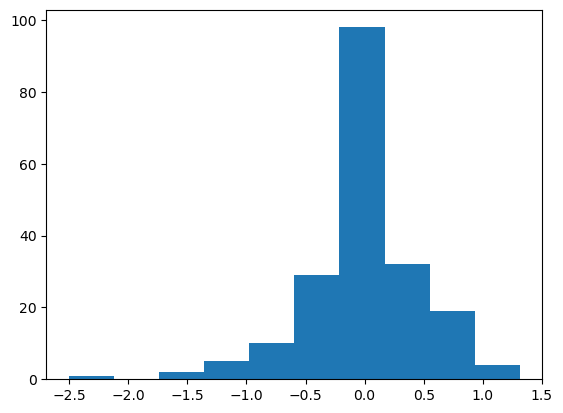

In [99]:
C, W1, b1, W2, b2 = params
plt.hist(b1.detach().numpy())

In [107]:
b2.shape

torch.Size([27])

(array([3., 5., 3., 4., 3., 3., 3., 0., 1., 2.]),
 array([-1.15215838, -0.86508399, -0.57800961, -0.29093522, -0.00386083,
         0.28321356,  0.57028794,  0.85736233,  1.14443672,  1.43151116,
         1.71858549]),
 <BarContainer object of 10 artists>)

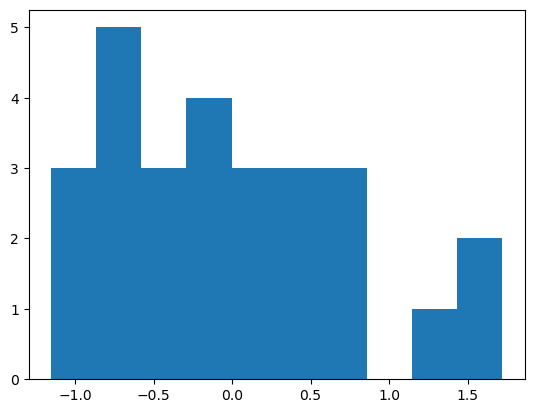

In [100]:
plt.hist(b2.detach().numpy())

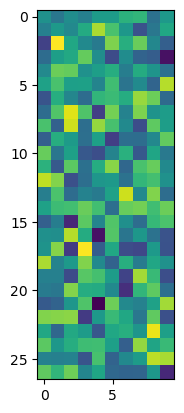

In [104]:
plt.imshow(C.detach().numpy())

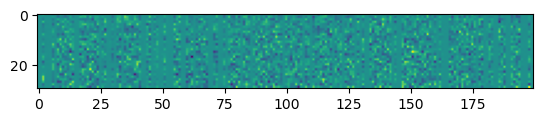

In [105]:
plt.imshow(W1.detach().numpy())

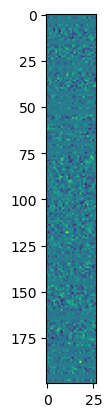

In [106]:
plt.imshow(W2.detach().numpy())